## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.utils import resample

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
62532,00015487_002.png,No Finding,2,15487,24,M,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00015487_002.png
88687,00021972_023.png,Atelectasis|Consolidation,23,21972,49,F,PA,2686,2991,0.143,0.143,NaN,/data/images_010/images/00021972_023.png
75244,00018464_009.png,No Finding,9,18464,57,F,PA,2292,2549,0.143,0.143,NaN,/data/images_009/images/00018464_009.png


In [3]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
maplist=list(all_xray_df['Finding Labels'].map(lambda x: x.split('|') ))
 
df=pd.DataFrame(maplist)[0]
realList=pd.Series(df).drop_duplicates().tolist()
 
for item in realList:
    all_xray_df[item] = all_xray_df['Finding Labels'].map(lambda finding: 1 if item in finding else 0)
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia']
all_xray_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Nodule,Emphysema,Atelectasis,Pleural_Thickening,Pneumothorax,Fibrosis,Consolidation,Edema,Pneumonia,pneumonia_class
108859,00029547_000.png,Infiltration,0,29547,62,F,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,0,0,0
16959,00004546_000.png,Nodule,0,4546,36,M,PA,2500,2048,0.171000,...,1,0,0,0,0,0,0,0,0,0
104675,00028027_006.png,Effusion|Mass,6,28027,34,F,AP,3056,2544,0.139000,...,0,0,0,0,0,0,0,0,0,0


In [4]:
all_xray_df["pneumonia_class"].value_counts()

0    110689
1      1431
Name: pneumonia_class, dtype: int64

## Create your training and testing data:

In [5]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    #I'll split it to 80 by 20
    msk = np.random.rand(len(vargs)) < 0.8
    
    train = vargs[msk]
    

    valid = vargs[~msk]

     # Separate majority and minority classes
    #seperate majority class from minority
    train_minor=train[train["pneumonia_class"]==1] 
    train_major=train[train["pneumonia_class"]==0] 
    df_minority_upsampled = resample(train_minor, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(train_major),     # to match majority class
                                     random_state=123) # reproducible results
    # Combine majority class with upsampled minority class
    train_data = pd.concat([train_major, df_minority_upsampled])

    val_minor=valid[valid["pneumonia_class"]==1] 
    val_major=valid[valid["pneumonia_class"]==0] 
    df_minority_upsampled = resample(val_minor, 
                                     replace=True,     # sample with replacement
                                     n_samples=len(val_minor)*30,     # to match majority class
                                     random_state=123) # reproducible results
    val_data = pd.concat([val_major, df_minority_upsampled])
 

    
    return train_data, val_data
 
tr=create_splits(all_xray_df)[0]
vl=create_splits(all_xray_df)[1]
 

In [6]:

len(tr[tr["pneumonia_class"]==0] )
tr['pneumonia_class'].sum()/len(tr) #let's see the len rate of balanced train


0.5

In [7]:
vl['pneumonia_class'].sum()/len(vl) #let's see the len rate of val

0.27619422056221743

In [8]:
all_xray_df["pneumonia_class"]=all_xray_df["pneumonia_class"].astype(str)

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [9]:
from keras_preprocessing.image import ImageDataGenerator
def my_image_augmentation(vargs):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    my_idg=ImageDataGenerator(rescale=1./255.,validation_split=0.2,zca_whitening=False,
                              rotation_range=0,fill_mode='reflect',zoom_range=0.0)
     
    return my_idg


def make_train_gen(vargs):
    
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    gen=my_image_augmentation(all_xray_df)
    train_gen = gen.flow_from_dataframe(dataframe = all_xray_df, 
                                              directory="/data/images_010/images", 
                                              x_col = "Image Index",
                                              y_col = "pneumonia_class",
                                              class_mode = 'binary',
                                              target_size = (32,32), 
                                              batch_size = 128,
                                              subset='training',
                                              validate_filenames=True) 

    return train_gen


def make_val_gen(vargs):
    
     
    validation_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
    val_gen = validation_datagen.flow_from_dataframe(dataframe = all_xray_df, 
                                              directory="/data/images_010/images", 
                                              x_col = "Image Index",
                                              y_col = "pneumonia_class",
                                              class_mode = 'binary',
                                              target_size = (32,32), 
                                                subset='validation',
                                              batch_size = 128) 
    
    
    return val_gen
train_gen=make_train_gen(all_xray_df)
val_gen=make_val_gen(all_xray_df)
 

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 102120 invalid image filename(s) in x_col="Image Index". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [10]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

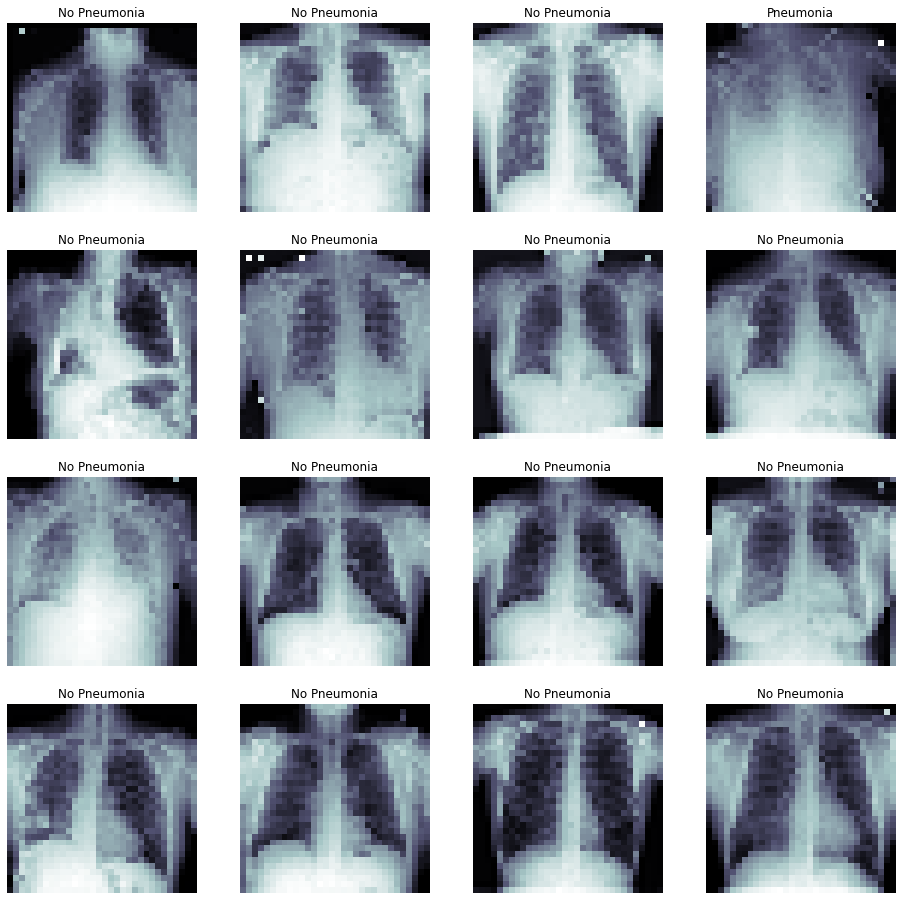

In [11]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
    

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [11]:
from keras.layers import Dense, GlobalAveragePooling2D,Dropout
from keras.models import Model
from keras.optimizers import Adam

from keras.applications.resnet50 import ResNet50
def load_pretrained_model(vargs):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

            # freeze ResNet50 first 24 weights
    for layer in base_model.layers[:24]:
        layer.trainable = False
        return base_model
    
 
        base_model.add(layer)
        if layer.name in ['fc1', 'fc2']:
            base_model.add(Dropout(.5))


base_model=load_pretrained_model(all_xray_df)

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [17]:
from keras.optimizers import SGD, Adamax, Adagrad, RMSprop
def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo

    
    
            # add new classification head
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(2, activation='sigmoid')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    my_model = Model(inputs=base_model.input, outputs=predictions)   
    adam= Adam(lr= 0.0001, decay=0.000001)
    
    sgd = SGD(lr=0.0001)
    adax=Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07 )
    my_model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['binary_accuracy'])
    #my_model.summary()


    return my_model

my_model=build_my_model(all_xray_df)

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [28]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]

from keras.callbacks import ModelCheckpoint, EarlyStopping
weight_path="{}_my_model.best.hdf5".format('xray_class')



checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_binary_accuracy',
                              verbose=1, 
                              save_best_only=True, 
                             #mode: For val_acc, this should be max, for val_loss this should be min
                              mode= "max", 
                              save_weights_only = True)
early = EarlyStopping(monitor= "val_binary_accuracy", 
                      #n auto mode, the direction is automatically inferred from the name of the monitored quantity.
                       mode= "auto", 
                       patience=15)

callbacks_list = [checkpoint, early]
callback = EarlyStopping(monitor='loss', patience=7) 

### Start training! 

In [29]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)

history = my_model.fit_generator(train_gen, 
                         validation_data = (valX, valY), 
                           epochs =35, 
                            class_weight='auto', #try to balance the labels
                           callbacks = callbacks_list)

Epoch 1/35
63/63 [==============================] - 116s 2s/step - loss: 0.7050 - binary_accuracy: 0.4881 - val_loss: 0.6234 - val_binary_accuracy: 0.7891

Epoch 00001: val_binary_accuracy improved from -inf to 0.78906, saving model to xray_class_my_model.best.hdf5
Epoch 2/35
63/63 [==============================] - 115s 2s/step - loss: 0.7003 - binary_accuracy: 0.5215 - val_loss: 0.6973 - val_binary_accuracy: 0.5078

Epoch 00002: val_binary_accuracy did not improve from 0.78906
Epoch 3/35
63/63 [==============================] - 115s 2s/step - loss: 0.6965 - binary_accuracy: 0.5340 - val_loss: 0.6969 - val_binary_accuracy: 0.5234

Epoch 00003: val_binary_accuracy did not improve from 0.78906
Epoch 4/35
63/63 [==============================] - 115s 2s/step - loss: 0.6917 - binary_accuracy: 0.5621 - val_loss: 0.6959 - val_binary_accuracy: 0.5234

Epoch 00004: val_binary_accuracy did not improve from 0.78906
Epoch 5/35
63/63 [==============================] - 116s 2s/step - loss: 0.6878 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [30]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

128/128 [==============================] - 0s 1ms/step


In [31]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    from sklearn import metrics
    #give me the maximum values for roc plottin
 

    #fpr, tpr, thresholds = metrics.roc_curve(t_y, p_y, pos_label=1)

    
    fpr, tpr, thresholds = metrics.roc_curve(t_y,p_y, pos_label=1)


    plt.plot(fpr,tpr,label="data 1, auc=")
    plt.legend(loc=4)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.show()    

    
    return ( fpr,tpr)

## what other performance statistics do you want to include here besides AUC? 

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,precision_recall_curve,average_precision_score
def cal_f1_score(lbl_true, lbl_pred):

    # Todo
    #get the average squared difference between the estimated values and the actual value.
    #accuracy=mean_squared_error(lbl_true, lbl_pred)
    accuracy=accuracy_score(lbl_true, lbl_pred)

    # precision tp / (tp + fp)
    precision = precision_score(lbl_true, lbl_pred, average="macro")
    # recall: tp / (tp + fn)
    recall = recall_score(lbl_true, lbl_pred, average="macro")
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(lbl_true, lbl_pred, average="macro")
    print('Accuracy: {}'.format(accuracy))
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('fscore: {}'.format(f1))
    
    prec, rec, threshold =precision_recall_curve(lbl_true, lbl_pred)
    plt.title('Plot Precision Recall')
    plt.plot(prec, rec, 'b', label = 'score = %0.2f' % average_precision_score(lbl_true,lbl_pred))
    return True

    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    # plot the training loss and accuracy
 
    print(history.history.keys())
   
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('Training   Accuracy on Dataset')
    plt.ylabel('accuracy')
    plt.xlabel('epoch #')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Training  loss on Dataset')
    plt.ylabel('accuracy')
    plt.xlabel('epoch #')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    return plt.savefig("Hplot.png")

def  f1_fomurlar(prec,recall):

    return 2*(prec*recall)/(prec+recall)
    


In [33]:
#cal_f1_score(valY, pred_Y)

# LET'S HAVE OUR PROBABILITY CLASSES
#get median of predicted class
threshold=np.median(pred_Y)

cut = threshold    
y_pred_prob = np.zeros_like(pred_Y)    # initialise a matrix full with zeros
y_pred_prob[pred_Y > cut] = 1   #subsitute a 1 if value is above median prediction 

from sklearn.metrics import mean_squared_error
mse=mean_squared_error(valY, y_pred_prob)
print(mse) 
 

0.5


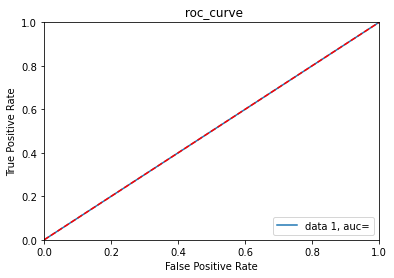

Accuracy: 0.5
Precision: 0.5
Recall: 0.5
fscore: 0.34673046251993617


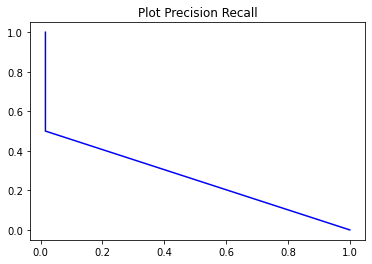

dict_keys(['val_loss', 'val_binary_accuracy', 'loss', 'binary_accuracy'])


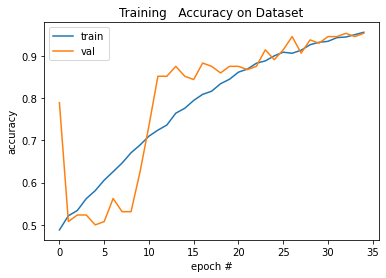

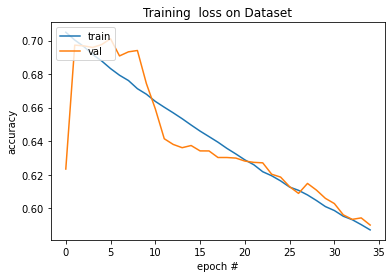

<Figure size 432x288 with 0 Axes>

In [35]:
## plot figures

# Todo
plt.title(' roc_curve') 
plot_auc(valY,y_pred_prob)
plt.show()    

 
cal_f1_score(valY,y_pred_prob)
plt.show()


plot_history(history)
plt.show()

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [107]:
print(classification_report(valY, y_pred_prob ))

              precision    recall  f1-score   support

         0.0       0.98      0.50      0.66       126
         1.0       0.02      0.50      0.03         2

    accuracy                           0.50       128
   macro avg       0.50      0.50      0.35       128
weighted avg       0.97      0.50      0.65       128



In [106]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

precision_value = 0.5
idx1 = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx1]))
print('Recall is: '+ str(recall[idx1]))
print('Threshold is: '+ str(thresholds[idx1]))
print('F1 Score is: ' + str(f1_fomurlar(precision[idx1],recall[idx1])))
thresh1 = thresholds[idx1]
print('\n', '-'*20, 'High recall', '-'*20, '\n')
recall_value = 0.5
idx2 = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx2]))
print('Recall is: '+ str(recall[idx2]))
print('Threshold is: '+ str(thresholds[idx2]))
print('F1 Score is: ' + str(f1_fomurlar(precision[idx2],recall[idx2])))
thresh2 = thresholds[idx2]

Precision is: 0.018691588785046728
Recall is: 1.0
Threshold is: 0.41653234
F1 Score is: 0.03669724770642201

 -------------------- High recall -------------------- 

Precision is: 0.009433962264150943
Recall is: 0.5
Threshold is: 0.41694063
F1 Score is: 0.018518518518518517


In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

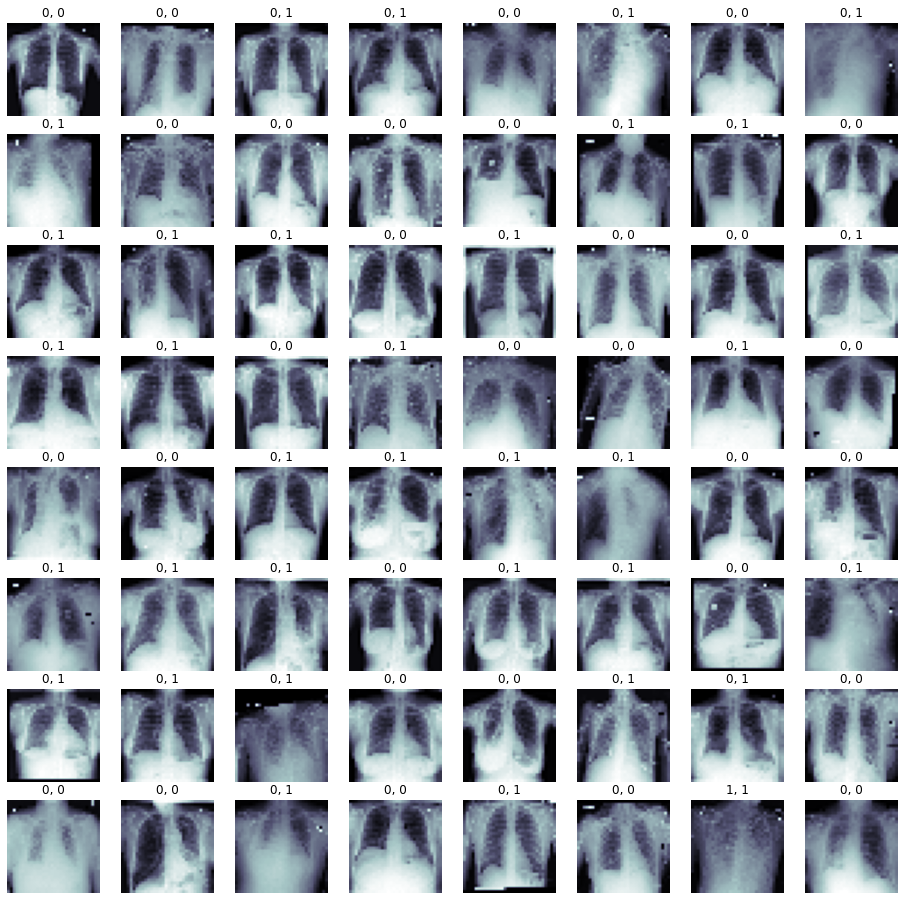

In [108]:
# Todo
YOUR_THRESHOLD = threshold
fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:64], valY[0:64], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [109]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)